In [85]:
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import pandas as pd
import numpy as np
import pickle

%aimport preprocessing
%aimport utils
%aimport p2v

from utils import prinT

pd.options.display.max_columns = None

In [87]:
model = p2v.P2V(load_raw_MAG=True)

2023-08-15 16:52:19 -- start loading 'paper_df'...
2023-08-15 16:52:20 -- finish.
2023-08-15 16:52:20 -- start loading 'ref_df'...
2023-08-15 16:52:31 -- finish.


In [95]:
model.load_MAG_venue_info_df()

2023-08-15 17:03:44 -- start loading Mag_venue_info_df
2023-08-15 17:03:44 -- finish.


In [33]:
model.load_paper_df(full_load=False, start_year=1980, end_year=1989)
model.load_ref_df(full_load=False, start_year=1980, end_year=1989)
prinT('generating \'paper_set\', start counting unique PIDs...')
model.target_paper_set = pd.unique(model.target_paper_df['PaperID'])
prinT("finish. %d papers and %d reference records in this decade. %d papers cited their peers" %(len(model.target_paper_set), len(model.target_ref_df), len(model.target_ref_df.index.unique())))
model.target_paper_df.set_index('PaperID', inplace=True)

2023-08-13 22:55:01 -- generating 'paper_set', start counting unique PIDs...
2023-08-13 22:55:03 -- finish. 7541503 papers and 21121496 reference records in this decade. 2697061 papers cited their peers


In [8]:
np.random.choice(model.target_paper_set)

1975816441

In [34]:
pid_origin = np.random.choice(model.target_paper_set)

pwalk = []
vwalk = []
vid = model.target_paper_df.at[pid_origin,'VenueID']
pwalk.append(pid_origin)
vwalk.append(vid)
pid = pid_origin
while 1:
    # ref_list: a Series containing PIDs of papers cited in a certain paper
    try:
        ref_list = model.target_ref_df.at[pid, 'PaperReferenceID']
    except KeyError:
        # the chosen paper has no reference
        # print("No reference!")
        break
    if type(ref_list) == np.uint32: # there is only one paper in the ref_list
        pid = ref_list
    else:
        pid = np.random.choice(ref_list)
    if pid in pwalk: # pid reoccurrs
        # print("PID reoccurrs!")
        vwalk = []
        break
    vid = model.target_paper_df.at[pid,'VenueID']
    pwalk.append(pid)
    vwalk.append(vid)

In [35]:
pwalk, vwalk

([1968522149, 1480579302, 1966536106, 1667731728, 2082063129],
 [7773033.0, 37672443.0, 37672443.0, 127916151.0, 125754415.0])

[2056362166, 2004267594, 910178502]

[192814187, 192814187, 34842069]
BMJ, BMJ, Journal of Endocrinology

[1968522149, 1480579302, 1966536106, 1667731728, 2082063129]

[7773033, 37672443, 37672443, 127916151, 125754415]
Macromolecular Symposia, FEBS Journal, FEBS Journal, The EMBO Journal, Proceedings of the National Academy of Sciences of the United States of America


In [ ]:
model.paper_df.loc[:,'Venue_name'] = model.paper_df['VenueID'].apply(lambda x: model.MAG_venue_info_df.at[x, 'OriginalVenue'])

In [31]:
model.target_paper_df.query('PaperID in [2056362166, 2004267594, 910178502]')

,PaperID,DocType,VenueID
Year,,,
1980-01-01,2004267594,Journal,192814187.0
1980-01-01,910178502,Journal,34842069.0
1981-01-01,2056362166,Journal,192814187.0


In [36]:
model.target_paper_df.query('PaperID in [1968522149, 1480579302, 1966536106, 1667731728, 2082063129]')

,DocType,VenueID
PaperID,,
2082063129,Journal,125754415.0
1667731728,Journal,127916151.0
1480579302,Journal,37672443.0
1966536106,Journal,37672443.0
1968522149,Journal,7773033.0


In [45]:
model.target_ref_df.loc[ 1966536106]

,PaperReferenceID
PaperID,
1966536106,1480579302
1966536106,1667731728
1966536106,2006472385
1966536106,2012631889
1966536106,2040360507
1966536106,2059548830


In [27]:
model.MAG_venue_info_df.query('VenueID in [192814187, 192814187, 34842069]')

,VenueType,OriginalVenue
VenueID,,
192814187,Journal,BMJ
34842069,Journal,Journal of Endocrinology


In [37]:
model.MAG_venue_info_df.query('VenueID in [7773033, 37672443, 37672443, 127916151, 125754415]')

,VenueType,OriginalVenue
VenueID,,
125754415,Journal,Proceedings of the National Academy of Science...
37672443,Journal,FEBS Journal
127916151,Journal,The EMBO Journal
7773033,Journal,Macromolecular Symposia


2023-08-14 00:58:17 -- start loading VID_labeled...
2023-08-14 00:58:17 -- finish.
2023-08-14 00:58:17 -- start loading wv_2d...
2023-08-14 00:58:17 -- finish.
2023-08-14 00:58:19 -- 20040 journals' map of sci fig for 2010 to 2021 saved to file!


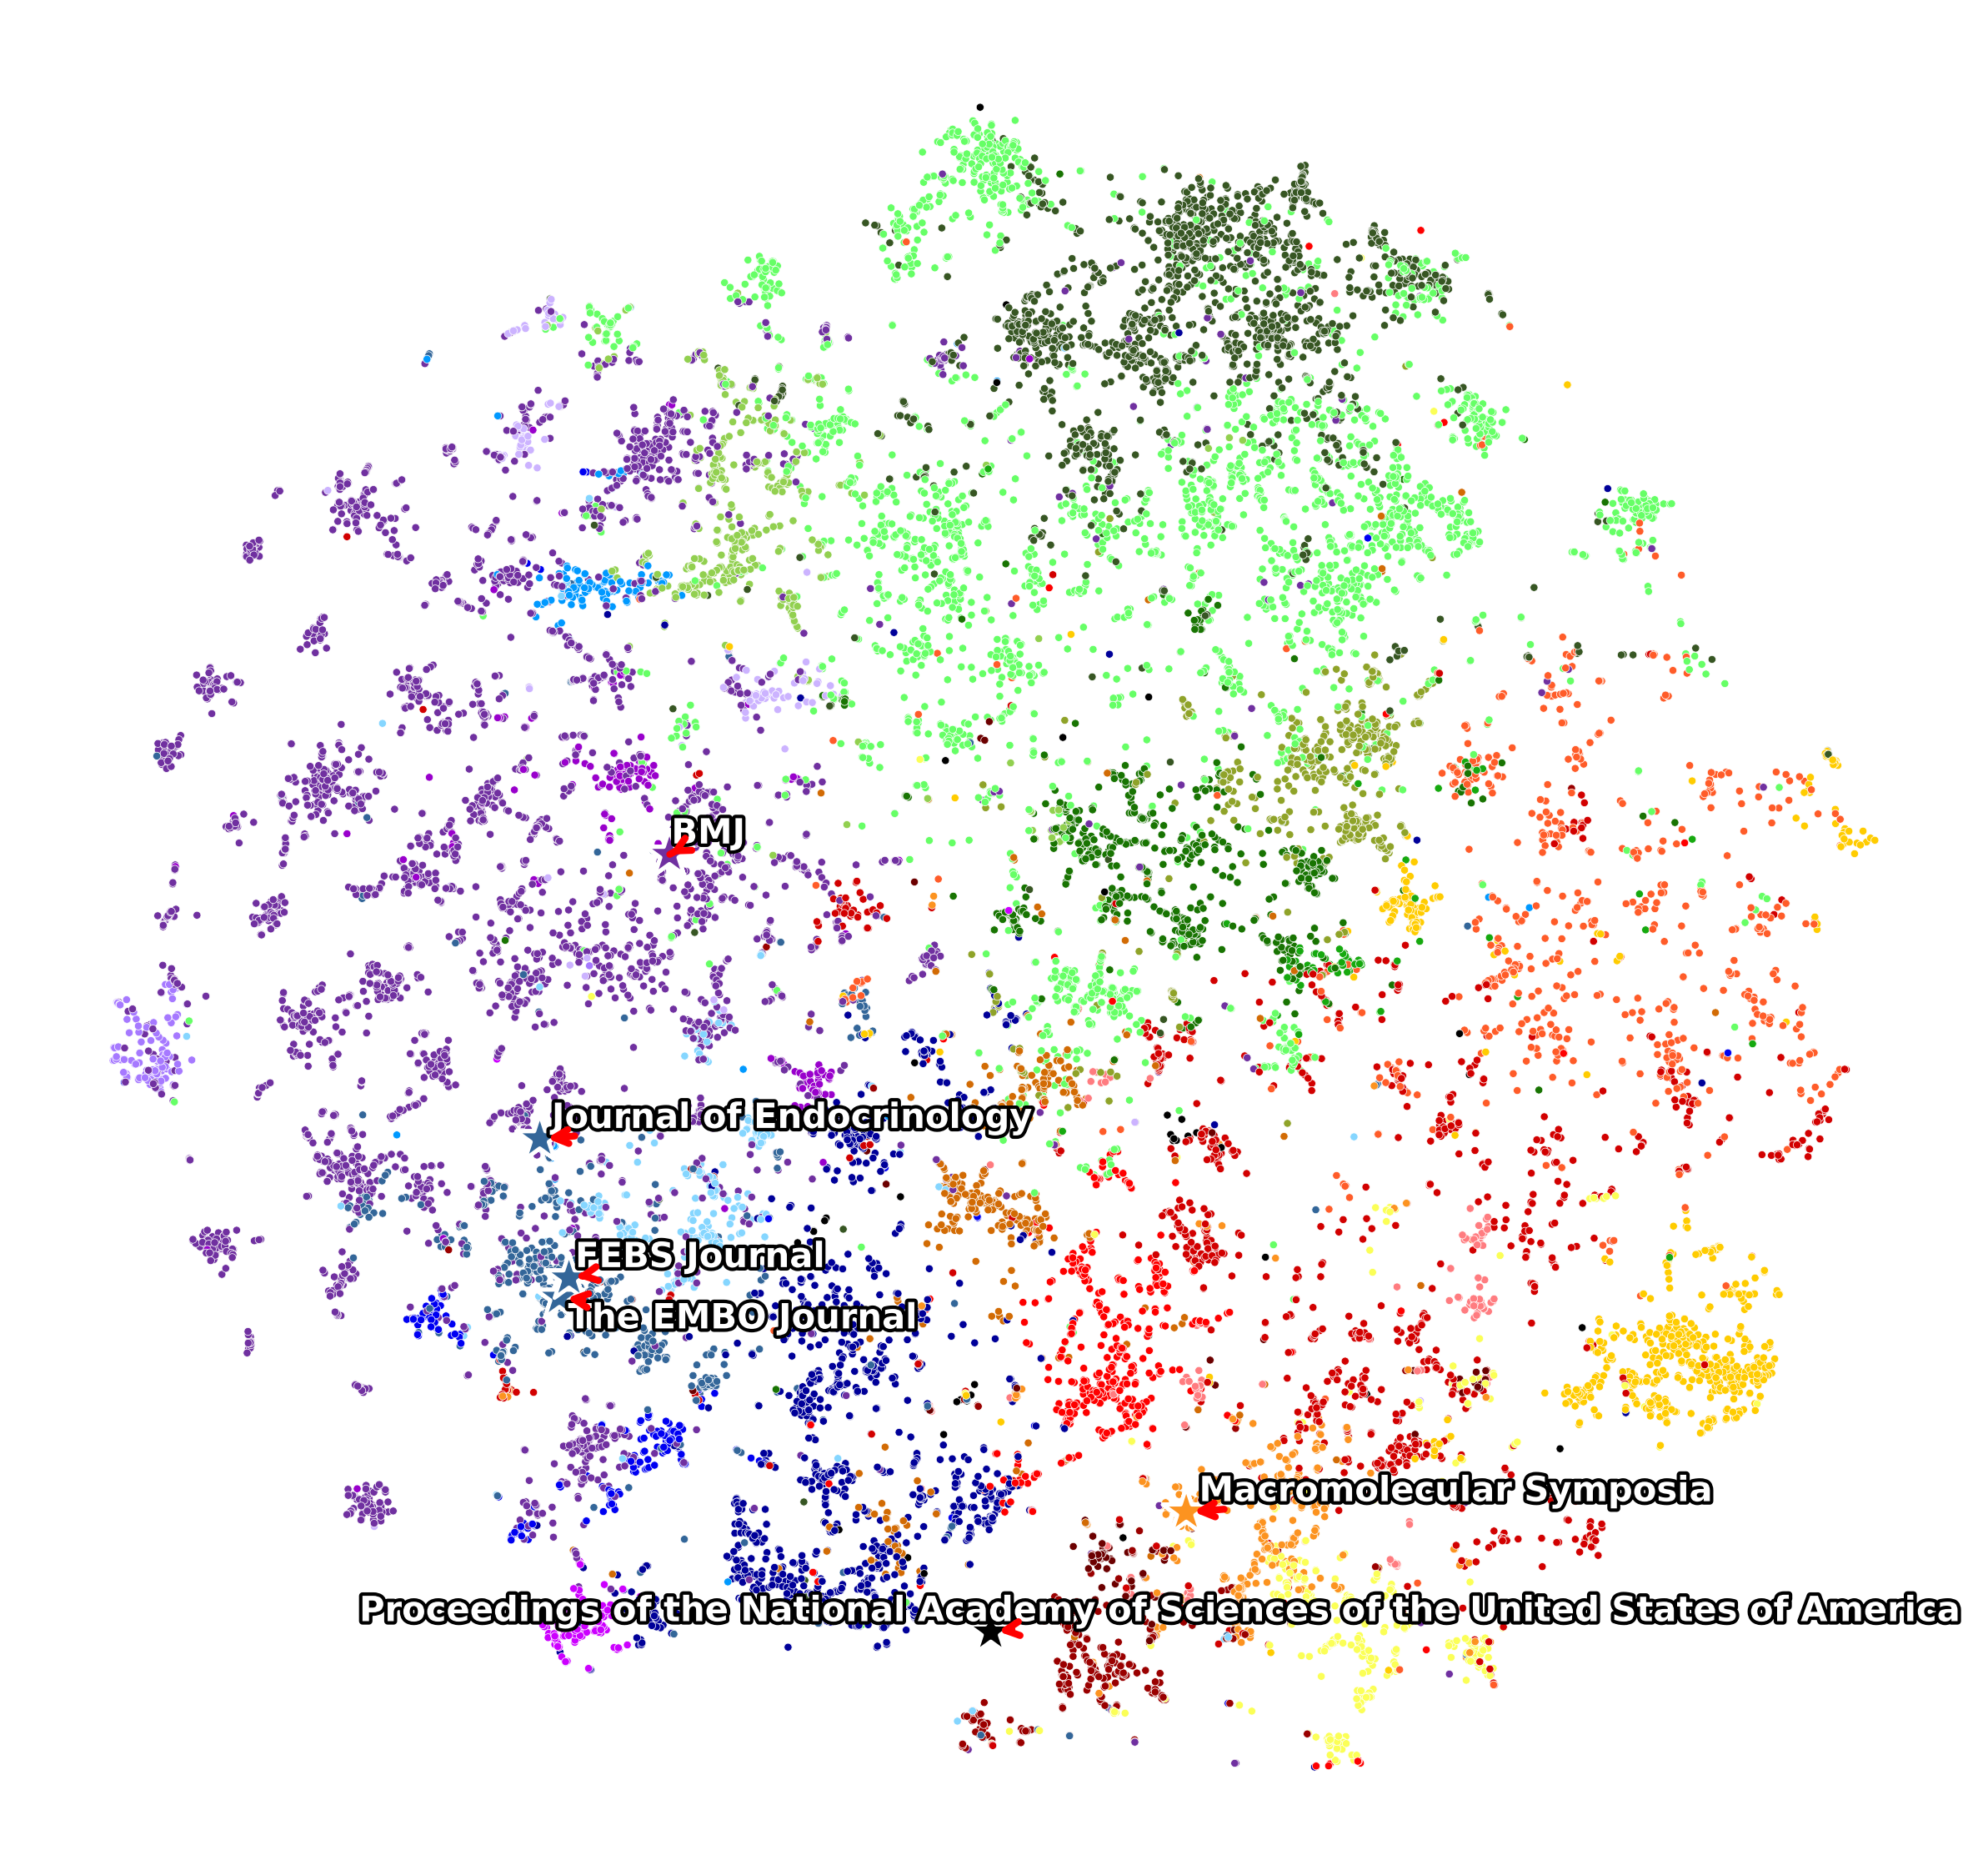

In [84]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from adjustText import adjust_text
import seaborn as sns
import os

start_year, end_year, d, w = 2010,2021, 100, 10 
y_flip=True
rotate_90=False
rotate_90_clockwise=False
rotate_180=False
save_fig=True
annotate=True

VID_list = [192814187, 34842069, 7773033, 37672443, 127916151, 125754415]
    
VID_labeled = model.load_VID_labeled(start_year, end_year, d, w)
wv_2d = model.load_wv_2d(start_year, end_year, d, w)

plot_df = pd.DataFrame(wv_2d)
plot_df = plot_df.loc[plot_df.VID.isin(VID_labeled['VID'])]
plot_df['label'] = VID_labeled['label']
plot_df['year_founded'] = VID_labeled['year_founded']
plot_df['is_new'] = plot_df['year_founded'].apply(lambda x: 
                                                  0 if x==None
                                                  else 1 if int(x)>start_year
                                                  else 0)

fig = plt.figure(figsize=(10, 10), dpi=300)
ax1 = plt.gca()
ax1.set_aspect('equal')

if annotate:
    point_alpha = 1.0
else:
    point_alpha = 1.0

if y_flip:
    plot_df['x_val'] = -1 * plot_df['x_val']
original_x = plot_df['x_val']
original_y = plot_df['y_val']
if rotate_180:
    plot_df['x_val'] = -1 * original_x
    plot_df['y_val'] = -1 * original_y
if rotate_90:
    plot_df['x_val'] = -1 * original_y
    plot_df['y_val'] = original_x
if rotate_90_clockwise:
    plot_df['x_val'] = original_y
    plot_df['y_val'] = -1 * original_x

sns.scatterplot(data=plot_df, 
                x='x_val', 
                y='y_val', 
                hue='label',
                hue_order=model.discipline2color.keys(),
                palette=model.discipline2color,
                alpha=point_alpha,
                s=5,
                ax=ax1,
                legend=False)

ax1.axis('off')

texts = []
for VID in VID_list:
    text = plt.text(plot_df[plot_df.VID==VID].x_val.values[0], 
                    plot_df[plot_df.VID==VID].y_val.values[0], 
                    model.MAG_venue_info_df.at[VID, 'OriginalVenue'],
                    fontsize=10,
                    color='white',
                    fontweight='bold',
                    ha='center')
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), path_effects.Normal()])
    texts.append(text)
    
    neighbor_df = plot_df.loc[plot_df.VID.isin(VID_list)]
    sns.scatterplot(data=neighbor_df, 
                    x='x_val', 
                    y='y_val', 
                    hue='label',
                    hue_order = model.discipline2color.keys(),
                    palette=model.discipline2color,
                    s=200,
                    marker='*',
                    ax=ax1,
                    legend=False)
adjust_text(texts, arrowprops=dict(arrowstyle='->', lw=2, color='red'))

if save_fig:
    dirs = '/media/sdb/p2v/figs/decades/%s_to_%s/' %(start_year, end_year)
    if not os.path.exists(dirs):
        os.makedirs(dirs)
    fig.savefig('/media/sdb/p2v/figs/decades/%s_to_%s/map_of_sci.pdf' %(start_year, end_year), 
                dpi = 300, 
                facecolor='white', 
                transparent=False, 
                bbox_inches='tight')
    prinT("%d journals' map of sci fig for %s to %s saved to file!" %(len(plot_df), start_year, end_year))

In [45]:
model.load_paper_df(full_load= False, start_year=1951, end_year=1960)
model.load_ref_df(full_load= False, start_year=1951, end_year=1960)

In [46]:
queryword = 'Journal'
model.target_paper_df.query('DocType == @queryword')

,PaperID,DocType,VenueID
Year,,,
1951-01-01,2438057491,Journal,2.755499e+09
1951-01-01,2109684203,Journal,2.530729e+09
1951-01-01,2443900113,Journal,2.754580e+09
1951-01-01,2087540062,Journal,1.660024e+08
1951-01-01,2061514788,Journal,9.025978e+07
...,...,...,...
1960-01-01,939193592,Journal,2.489148e+07
1960-01-01,2109107612,Journal,6.739351e+07
1960-01-01,2404287824,Journal,1.239032e+07


In [16]:
queryword = 'Conference'
model.paper_df.query('DocType == @queryword')

,PaperID,DocType,VenueID
Year,,,
1800-01-01,2599414969,Conference,1130451194
1800-01-01,2605904531,Conference,2754666132
1800-01-01,2610132626,Conference,2244759375
1800-01-01,2593944920,Conference,2238538125
1800-01-01,2617650505,Conference,1130451194
...,...,...,...
2022-01-01,3206680771,Conference,1121344769
2022-01-01,3216452752,Conference,2754632699
2022-01-01,3216730646,Conference,1173897633


In [3]:
model = p2v.P2V()

2023-08-13 22:45:37 -- start loading Mag_venue_info_df
2023-08-13 22:45:37 -- finish.
2023-08-13 22:45:37 -- start loading labeled_journal_info_df
2023-08-13 22:45:37 -- finish.


In [30]:
model.labeled_journal_info_df[
model.labeled_journal_info_df['OriginalVenue'].str.contains('Journal of Biological Chemistry')]

,VenueType,OriginalVenue,ScopusName,ScopusCategory,InceptionYear
VenueID,,,,,
140251998,Journal,Journal of Biological Chemistry,Journal of Biological Chemistry,Cell Biology;;Molecular Biology;;Biochemistry,1905
104198154,Journal,International Journal of Biological Chemistry,International Journal of Biological Chemistry,Pharmacology;;Biochemistry,None


In [99]:
from collections import Counter
for i in range(len(model.start_year_list)-7,len(model.start_year_list)):
    print(model.start_year_list[i])

    label_list = model.load_VID_labeled(start_year=model.start_year_list[i], end_year=model.end_year_list[i], d=100, w=10)['label']
    one_year_pd = pd.DataFrame.from_dict(Counter(label_list), orient='index', columns=['count'])
    one_year_pd['percent'] = one_year_pd['count']/len(label_list)*100
    one_year_pd.columns = [[model.start_year_list[i]+'s', model.start_year_list[i]+'s'], ['count','percent']]
    if model.start_year_list[i] == '1950':
        total_pd = one_year_pd
    else:
        total_pd = total_pd.merge(one_year_pd, left_index=True, right_index=True)

1950
2023-08-25 17:59:38 -- start loading VID_labeled...
2023-08-25 17:59:38 -- finish.
1960
2023-08-25 17:59:38 -- start loading VID_labeled...
2023-08-25 17:59:38 -- finish.
1970
2023-08-25 17:59:38 -- start loading VID_labeled...
2023-08-25 17:59:38 -- finish.
1980
2023-08-25 17:59:38 -- start loading VID_labeled...
2023-08-25 17:59:38 -- finish.
1990
2023-08-25 17:59:38 -- start loading VID_labeled...
2023-08-25 17:59:38 -- finish.
2000
2023-08-25 17:59:38 -- start loading VID_labeled...
2023-08-25 17:59:38 -- finish.
2010
2023-08-25 17:59:38 -- start loading VID_labeled...
2023-08-25 17:59:38 -- finish.


In [100]:
total_pd

1950s            1960s  \
                                             count    percent count   
Multidisciplinary                                8   0.625000     9   
Biochemistry, Genetics and Molecular Biology    67   5.234375   112   
Physics and Astronomy                           48   3.750000    94   
Chemistry                                       38   2.968750    91   
Medicine                                       351  27.421875   526   
Immunology and Microbiology                     18   1.406250    26   
Engineering                                     62   4.843750   187   
Arts and Humanities                            111   8.671875   196   
Agricultural and Biological Sciences           161  12.578125   274   
Dentistry                                       10   0.781250    18   
Materials Science                               11   0.859375    50   
Nursing                                          5   0.390625    13   
Psychology                                      33   2.578125    62   
Earth and Planetary Sciences                    80   6.250000   139   
Decision Sciences                                4   0.312500     2   
Mathematics                                     73   5.703125   137   
Pharmacology, Toxicology and Pharmaceutics      13   1.015625    35   
Environmental Science                            4   0.312500    21   
Social Sciences                                132  10.312500   303   
Neuroscience                                     2   0.156250     8   
Chemical Engineering                             8   0.625000    16   
Veterinary                                       4   0.312500    15   
Economics, Econometrics and Finance             21   1.640625    48   
Energy                                           3   0.234375     9   
Computer Science                                 7   0.546875    14   
Business, Management and Accounting              3   0.234375    17   
Health Professions                               3   0.234375     8   

                                                        1970s             \
                                                percent count    percent   
Multidisciplinary                              0.370370    14   0.323475   
Biochemistry, Genetics and Molecular Biology   4.609053   184   4.251386   
Physics and Astronomy                          3.868313   151   3.488909   
Chemistry                                      3.744856   126   2.911275   
Medicine                                      21.646091   901  20.817930   
Immunology and Microbiology                    1.069959    70   1.617375   
Engineering                                    7.695473   287   6.631238   
Arts and Humanities                            8.065844   359   8.294824   
Agricultural and Biological Sciences          11.275720   402   9.288355   
Dentistry                                      0.740741    26   0.600739   
Materials Science                              2.057613    77   1.779113   
Nursing                                        0.534979    30   0.693161   
Psychology                                     2.551440   137   3.165434   
Earth and Planetary Sciences                   5.720165   211   4.875231   
Decision Sciences                              0.082305    11   0.254159   
Mathematics                                    5.637860   200   4.621072   
Pharmacology, Toxicology and Pharmaceutics     1.440329    67   1.548059   
Environmental Science                          0.864198    68   1.571165   
Social Sciences                               12.469136   651  15.041590   
Neuroscience                                   0.329218    35   0.808688   
Chemical Engineering                           0.658436    28   0.646950   
Veterinary                                     0.617284    31   0.716266   
Economics, Econometrics and Finance            1.975309   112   2.587800   
Energy                                         0.370370    19   0.439002   
Computer 

In [16]:
total_pd.loc[:,'2010s'].sort_values(by=['count'], ascending=False)

,count,percent
Medicine,4635,23.128743
Social Sciences,3250,16.217565
Arts and Humanities,1571,7.839321
Agricultural and Biological Sciences,1373,6.851297
Engineering,1146,5.718563
Mathematics,744,3.712575
"Biochemistry, Genetics and Molecular Biology",724,3.612774
"Business, Management and Accounting",708,3.532934
Computer Science,656,3.273453
Earth and Planetary Sciences,570,2.844311


In [91]:
model.paper_df[model.paper_df.DocType=='Journal'].info

<bound method DataFrame.info of                PaperID  DocType       VenueID
Year                                         
1800-01-01  3206416479  Journal  2.360835e+06
1800-01-01  3205676634  Journal  1.489219e+08
1800-01-01  3092044961  Journal  3.006143e+09
1800-01-01  3092547797  Journal  3.006143e+09
1800-01-01  2895498877  Journal  1.180823e+08
...                ...      ...           ...
2022-01-01  3212273925  Journal  4.445530e+07
2022-01-01  3175031963  Journal  2.764413e+09
2022-01-01  3198241111  Journal  6.771676e+07
2022-01-01  3202490341  Journal  1.665413e+08
2022-01-01  3213752308  Journal  8.968968e+07

[90864700 rows x 3 columns]>

In [92]:
model.paper_df[model.paper_df.DocType=='Conference'].info

<bound method DataFrame.info of                PaperID     DocType       VenueID
Year                                            
1800-01-01  3206379461  Conference  1.182310e+09
1800-01-01  2593944920  Conference  2.238538e+09
1800-01-01  2611458328  Conference  1.130451e+09
1800-01-01  2617650505  Conference  1.130451e+09
1800-01-01  2609795239  Conference  2.622580e+09
...                ...         ...           ...
2022-01-01  3213636142  Conference  1.121345e+09
2022-01-01  3200457312  Conference  1.164519e+09
2022-01-01  3153863026  Conference  2.754695e+09
2022-01-01  3210178628  Conference  1.198780e+09
2022-01-01  3186765195  Conference  1.198780e+09

[5207724 rows x 3 columns]>

In [93]:
model.paper_df.info

<bound method DataFrame.info of                PaperID  DocType       VenueID
Year                                         
1800-01-01  3206416479  Journal  2.360835e+06
1800-01-01  3205676634  Journal  1.489219e+08
1800-01-01  3092044961  Journal  3.006143e+09
1800-01-01  3092547797  Journal  3.006143e+09
1800-01-01  2895498877  Journal  1.180823e+08
...                ...      ...           ...
2022-01-01  3212273925  Journal  4.445530e+07
2022-01-01  3175031963  Journal  2.764413e+09
2022-01-01  3198241111  Journal  6.771676e+07
2022-01-01  3202490341  Journal  1.665413e+08
2022-01-01  3213752308  Journal  8.968968e+07

[96072424 rows x 3 columns]>

In [97]:
model.MAG_venue_info_df[model.MAG_venue_info_df.VenueType=='Journal'].info

<bound method DataFrame.info of            VenueType                               OriginalVenue
VenueID                                                         
3006142753   Journal  Proceedings of The Royal Society of London
194691280    Journal                          Annalen der Physik
177993953    Journal                Journal of Literacy Research
168309380    Journal                      Philosophical Magazine
93133213     Journal            Western Journal of Communication
...              ...                                         ...
3205679767   Journal   RMS: Research in Mathematics & Statistics
938070683    Journal               Corporate Philanthropy Report
946020915    Journal                    Africa Research Bulletin
6224198      Journal        Loisir & Societe-society and Leisure
972822541    Journal          Journal of Home Economics Research

[49006 rows x 2 columns]>

In [89]:
model.ref_df.info

<bound method DataFrame.info of             PaperReferenceID
PaperID                     
108               2155007194
147                132242577
147               1973725016
147               2084894991
147               2091764496
...                      ...
3217810962        3084899668
3217810962        3091202117
3217810962        3138603596
3217810962        3179226512
3217810962        3179705375

[1250348988 rows x 1 columns]>